# Bibliotecas

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math
import pandas as pd

# Funções

In [176]:
def calculate_divided_differences(x, y):
    diffs = []
    diffs.append(y)
    for i in range(len(x)-1):
        diff = []
        for j in range(len(diffs[i])-1):
            d = (diffs[i][j+1] - diffs[i][j]) / (x[j+i+1] - x[j])
            diff.append(d)
        diffs.append(diff)
    return diffs

def make_score_table(diffs):
    score = dict()

    for i in range(len(diffs)):
        score[f'Ordem {i}'] = [np.mean(diffs[i]), np.var(diffs[i]), np.std(diffs[i])]

    score = pd.DataFrame(score, index=['Média', 'Variância', 'Desvio Padrão'])
    return score

# Métodos

In [177]:
def lagrange_method(x, y, z):
    pz = 0
    x_len = len(x)
    for i in range(x_len):
        c = 1
        d = 1
        for j in range(x_len):
            if i != j:
                c *= (z - x[j])
                d *= (x[i] - x[j])
        pz += (y[i] * c) / d

    return pz

def newton_method(x, y, z):
    x_len = len(x)
    dy = y

    for i in range(x_len-1):
        for k in range(x_len-1, i, -1):
            dy[k] = (dy[k] - dy[k-1]) / (x[k] - x[k-i-1])

    return solve_newton(x, z, dy), dy

def solve_newton(x, z, dy):
    x_len = len(x)
    pz = dy[x_len-1]
    for i in range(x_len-1, 0, -1):
        pz = (pz * (z - x[i-1])) + dy[i-1]

    return pz

In [178]:
def cubic_spline_method(x, y):
    x_len = len(x)

    if x_len < 3:
        raise ValueError('Não há pontos o suficiente (min = 3).')

    sorted = True
    for i in range(1, x_len):
        sorted = sorted and (x[i-1] < x[i])

    if not sorted:
        return -2

    A = np.zeros((x_len-2, x_len), dtype=float)
    b = np.zeros(x_len-2, dtype=float)

    h = []
    line = 0
    for i in range(x_len-2):
        h1 = x[i+1] - x[i]
        h2 = x[i+2] - x[i+1]
        h.append(h1)

        A[line][i] = h1
        A[line][i+1] = 2*(h1+h2)
        A[line][i+2] = h2

        d2 = (y[i+2] - y[i+1])/h2
        d1 = (y[i+1] - y[i])/h1

        b[i] = 6*(d2 - d1)
        line += 1

    h.append(h2)
    A = A[0:x_len-2, 1:x_len-1]
    g = np.zeros(x_len)
    g[1:x_len-1] = np.linalg.solve(A, b)

    return g, h

def mount_equation(g, h, y):
    h_len = len(h)
    a = np.arange(h_len,dtype=float)
    b = np.arange(h_len,dtype=float)
    c = np.arange(h_len,dtype=float)
    d = np.arange(h_len,dtype=float)

    g_len = len(g)
    for i in range(g_len-1, 0, -1):
        d[i-1] = (g[i] - g[i-1])/(6*h[i-1])
        c[i-1] = g[i]/2
        b[i-1] = ((y[i] - y[i-1])/h[i-1]) + ((2*h[i-1]*g[i] + g[i-1]*h[i-1])/6)
        a[i-1] = y[i]

    return np.array([a, b, c, d]).T

def estimate_xi(x, s, xe):
    c = len(np.where(xe < np.array(x))[0])

    if c != 0:
        index = len(x) - c
    else:
        index = len(x) - 1

    estimative = 0
    for i, k in enumerate(s[index-1]):
        estimative += k*((xe-x[index])**i)

    return estimative

In [179]:
def linear_regression(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    len_x = len(x)

    st = 0
    sr = 0

    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x*y)
    sum_x2 = np.sum(x**2)

    mean_x = sum_x/len_x
    mean_y = sum_y/len_x

    a1 = (len_x*sum_xy - sum_x*sum_y)/(len_x*sum_x2 - sum_x**2)
    a0 = mean_y - a1*mean_x

    for i in range(len_x):
        st += (y[i] - mean_y)**2
        sr += (y[i] - a1*x[i] - a0)**2
    syx = (sr/(len_x-2))**0.5
    r2 = (st - sr)/st

    return [a0,  a1], syx, r2

def quadratic_regression(x, y):
    n = len(x)

    x = np.array(x)
    y = np.array(y)

    sumx = np.sum(x)
    sumx_sq = np.sum(x**2)
    sumx_cb = np.sum(x**3)
    sumx_qu = np.sum(x**4)

    sumy = np.sum(y)
    sum_xy = np.sum(x*y)
    sum_x2y = np.sum((x**2)*y)

    A = np.ones((3,3))
    b = np.array([sum_x2y, sum_xy, sumy])

    A[:, 0] = [sumx_qu, sumx_cb, sumx_sq]
    A[:, 1] = [sumx_cb, sumx_sq, sumx]
    A[:, 2] = [sumx_sq, sumx, n]

    a, b, c = np.linalg.solve(A,b)
    f = lambda x,a,b,c: a*(x**2) + b*x + c

    SSE = np.sum((y - f(x, a, b, c))**2)
    SST = np.sum((y - np.mean(y))**2)
    r2 = 1 - (SSE/SST)

    return [a, b, c], r2

# Exercício 1

In [180]:
x = np.array([200,250,300,350,400,450], dtype=float)
y = np.array([1.708,1.367,1.139,0.967,0.854,0.759], dtype=float)

make_score_table(calculate_divided_differences(x.copy(), y.copy()))

,Ordem 0,Ordem 1,Ordem 2,Ordem 3,Ordem 4,Ordem 5
Média,1.132333,-0.003796,1.230000e-05,-4.222222e-08,5.333333e-11,-2.773333e-12
Variância,0.105115,0.000003,4.581000e-11,1.144099e-15,1.201778e-19,0.000000e+00
Desvio Padrão,0.324214,0.001778,6.768309e-06,3.382453e-08,3.466667e-10,0.000000e+00


A partir da tabela gerada do cálculo das diferenças divididas, pode-se perceber que tanto o polinômio de ordem 4 quanto o de ordem 5 terão uma excelente estimativa da função que descreve os pontos dados, pois sua variância e desvio padrão são muito menores do que os das demais ordens, logo, seus valores possuem menor variação.

In [181]:
x = np.array([200,250,300,350,400,450], dtype=float)
y = np.array([1.708,1.367,1.139,0.967,0.854,0.759], dtype=float)

rel_xy = dict(zip(x,y))

base_set = tuple((300, 350))
subsets = [base_set]
for i in range(3, len(x)+1):
    for comb in list(combinations(x,i)):
        if set(comb).issuperset(base_set):
            subsets.append(comb)

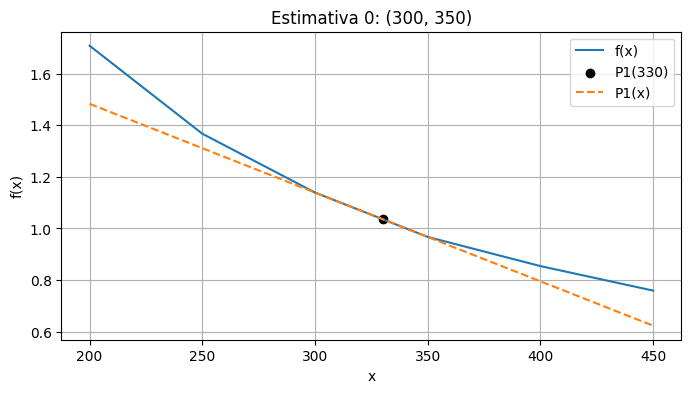

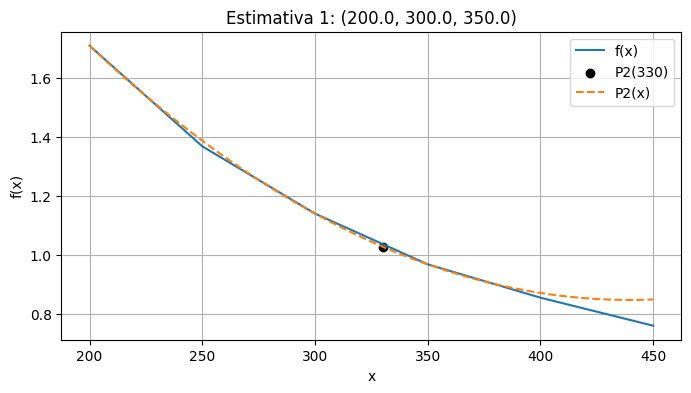

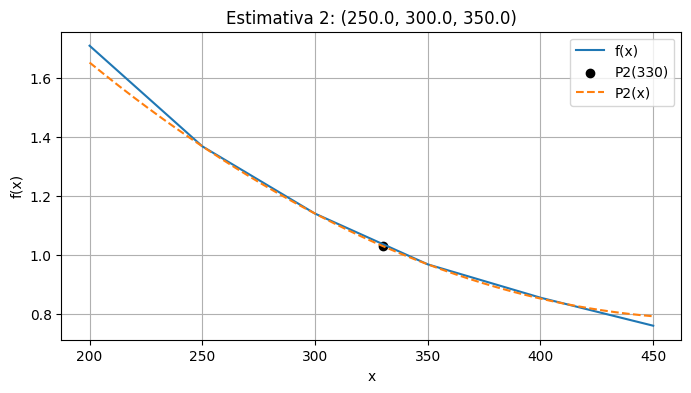

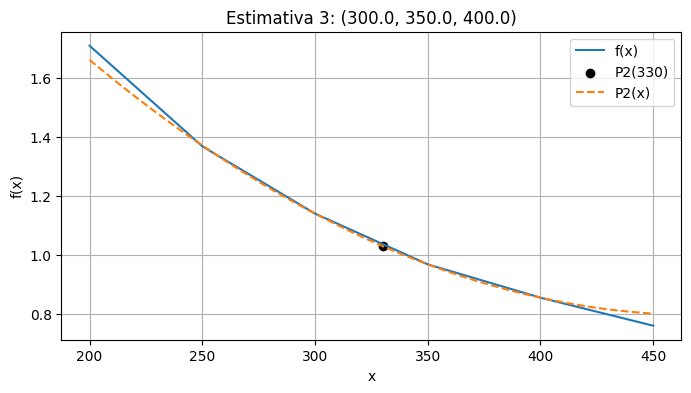

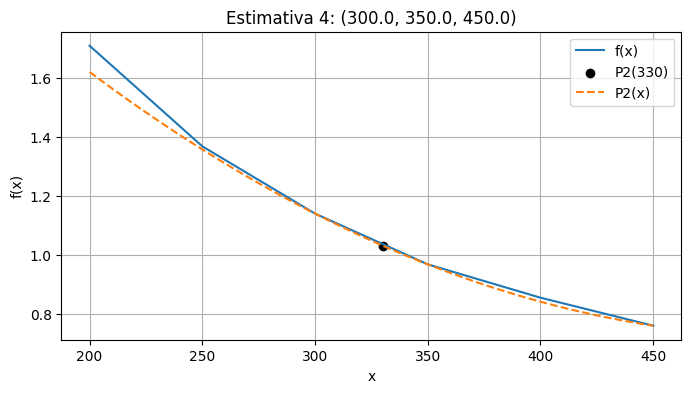

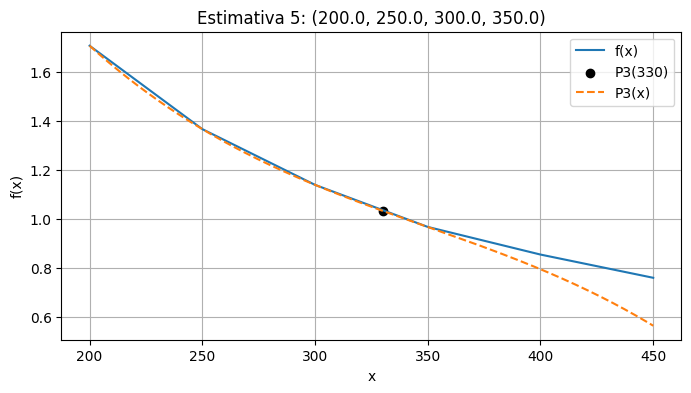

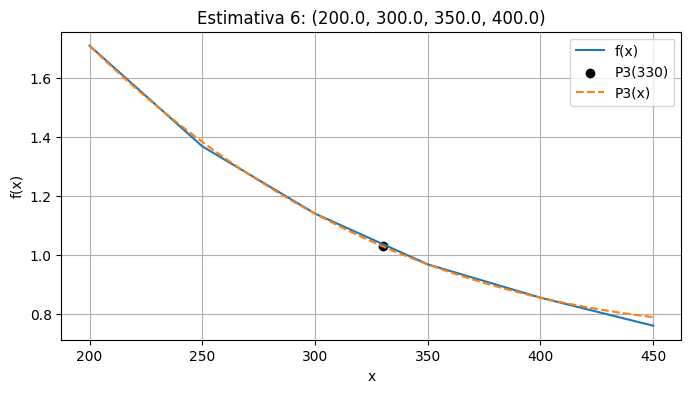

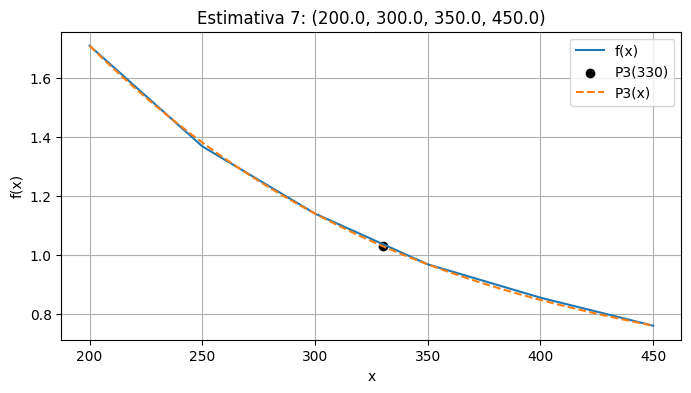

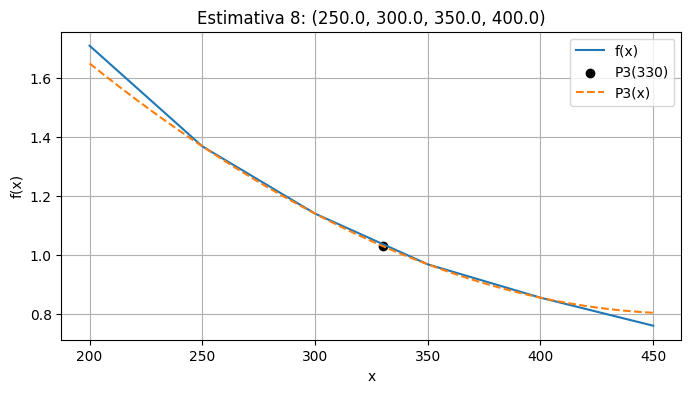

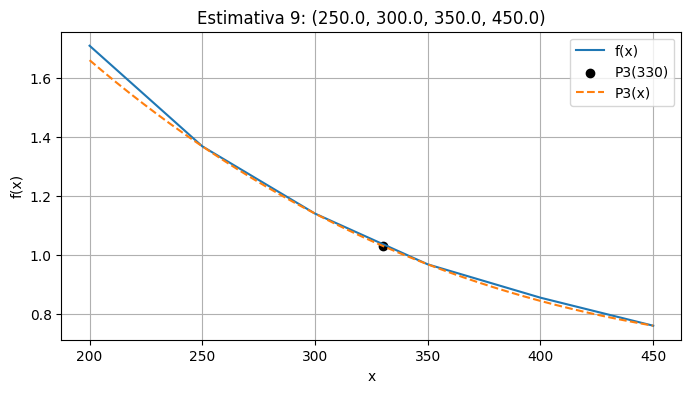

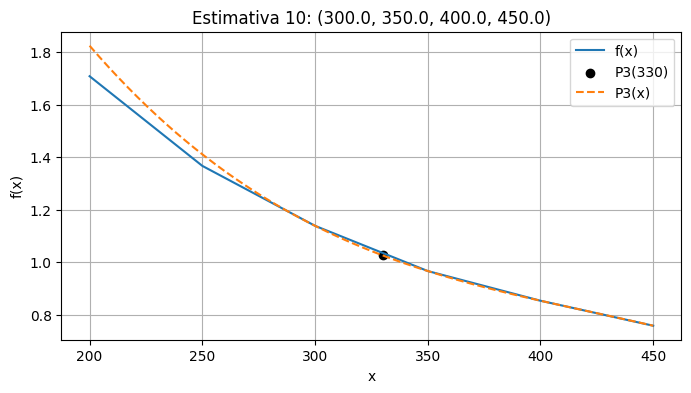

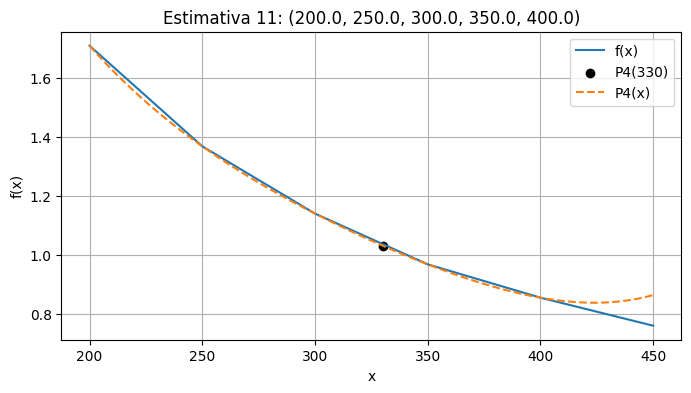

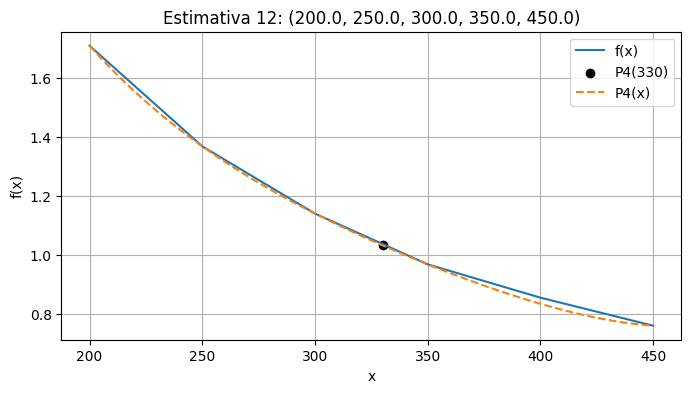

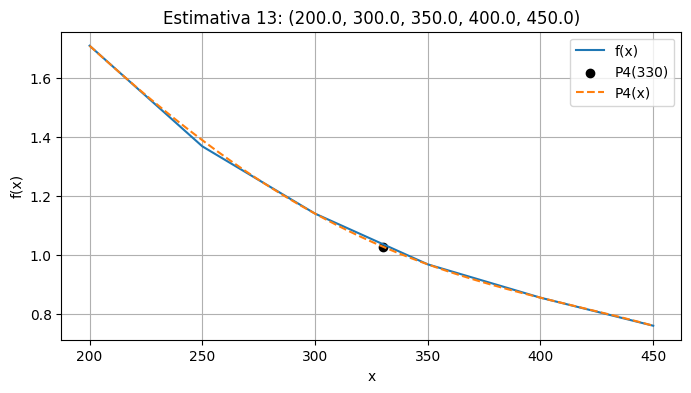

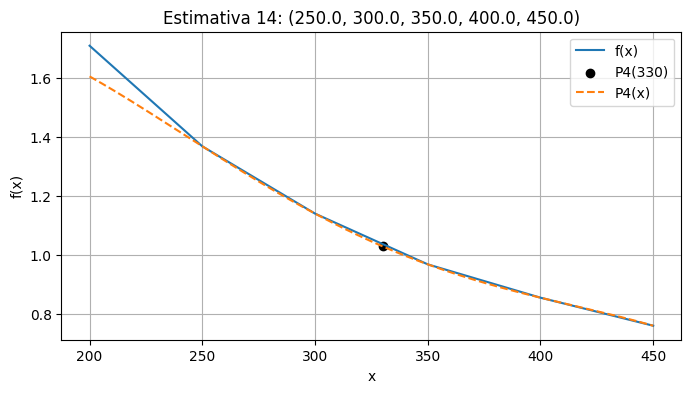

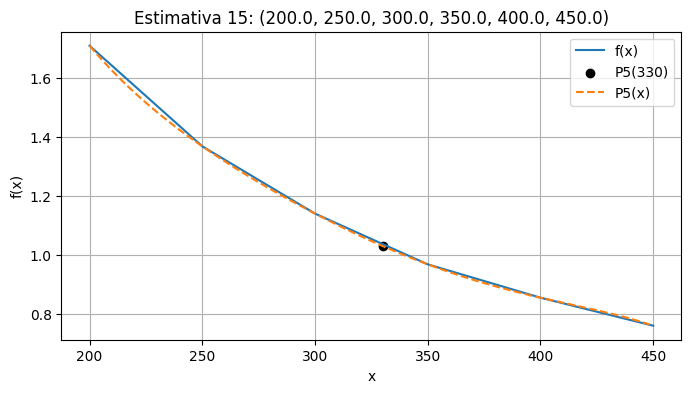

In [182]:
estimatives = []

for i, interval in enumerate(subsets):
    n = len(interval) - 1

    yi = [rel_xy[x] for x in list(interval)]
    linsp = np.linspace(200,450,1000)

    est, dy = newton_method(list(interval), yi, 330)
    estimatives.append(est)

    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label='f(x)')
    plt.scatter(330, est, label=f'P{n}(330)', color='black')
    plt.plot(linsp, solve_newton(list(interval), linsp, dy), label=f'P{n}(x)', linestyle='--')
    plt.title(f"Estimativa {i}: {str(interval)}")
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [183]:
estimatives

[1.0358,
 1.0268,
 1.02908,
 1.02872,
 1.03036,
 1.032728,
 1.028048,
 1.0286511999999999,
 1.028888,
 1.029592,
 1.026424,
 1.0302319999999998,
 1.03109728,
 1.02720352,
 1.0279023999999999,
 1.029020608]

Devido a ausencia do valor real da f(330), o que impede a estipulação de um erro preciso, pode-se inferir a qualidade das estimativas apenas pelo comportamento das curvas geradas quando comparadas à curva simplificada (composta pela união linear dos pontos dados no enunciado).

Tendo isso em vista, como esperado, é notável que os polinômios de ordem 4 e 5 produziram curvas mais suaves e semelhantes ao possível comportamento da f(x).

# Exercício 2

In [184]:
x = np.array([370,382,394,406,418], dtype=float)
y = np.array([5.9313,7.5838,8.8428,9.7960,10.5311], dtype=float)

v = lagrange_method(x.copy(), y.copy(), 400)
print('v(400) =', v)

v(400) = 9.352143749999998


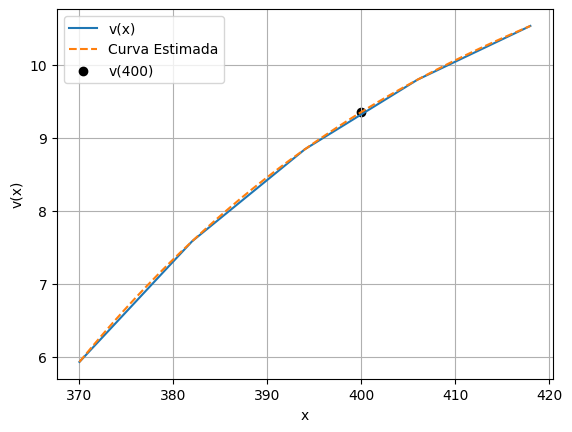

In [185]:
plt.plot(x, y, label='v(x)')
linsp = np.linspace(x[0], x[-1], 1000)
plt.plot(linsp, lagrange_method(x.copy(), y.copy(), linsp), label='Curva Estimada', linestyle='--')
plt.scatter(400, v, color='black', label='v(400)')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('v(x)')
plt.legend()
plt.show()

Embora não seja dado o valor real de v(400), é coerente, observando a curva em azul, dizer que tal valor se encontra entre 9 e 9.5l/kg. Portanto, o valor estimado de aproximadamente 9.35 é, provavelmente, bastante próximo ao valor real.

# Exercício 3

In [186]:
x = np.array([1.8, 2.0, 2.2, 2.4, 2.6], dtype=float)
j1 = np.array([0.5815,0.5767, 0.5560, 0.5202, 0.4708], dtype=float)

## Questão A

In [187]:
jx, dy = newton_method(x.copy(), j1.copy(), 2.1)
jx

0.56830390625

## Questão B

In [188]:
g, h = cubic_spline_method(x.copy(), j1.copy())
s = mount_equation(g, h, j1)
j21 = estimate_xi(x.copy(), s, 2.1)
j21

0.5684613839285715

## Newton Vs Spline Cúbica

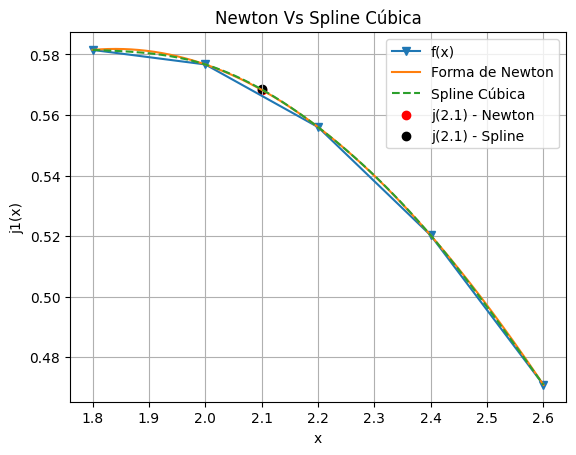

In [189]:
plt.plot(x, j1, label='f(x)', marker='v')
linsp = np.linspace(x[0], x[-1], 1000)
plt.plot(linsp, solve_newton(x.copy(), linsp, dy), label='Forma de Newton')
plt.plot(linsp, [estimate_xi(x.copy(), s, l) for l in linsp], label='Spline Cúbica', linestyle='--')
plt.scatter(2.1, jx, label='j(2.1) - Newton', color='red')
plt.scatter(2.1, j21, label='j(2.1) - Spline', color='black')
plt.grid(True)
plt.title('Newton Vs Spline Cúbica')
plt.xlabel('x')
plt.ylabel('j1(x)')
plt.legend()
plt.show()

Pelos resultados obtidos, o polinômio que mais se aproxima do valor real j1(2.1) é aquele gerado pela forma de Newton. Isso ocorre, provavelmente, devido ao spline ser um método que constrói o polinômio tendo em vista o comportamento local da função dada, logo, diferentes polinômios são gerados de acordo com cada intervalo, o que garante uma maior generalização por parte do modelo, formando uma curva mais "afastada" da real.

# Exercício 4

In [190]:
x = np.array([0, 5, 10, 20, 30, 40], dtype=float)
y = np.array([1.787, 1.519, 1.307, 1.002, 0.7975, 0.6529], dtype=float)

## Questão A

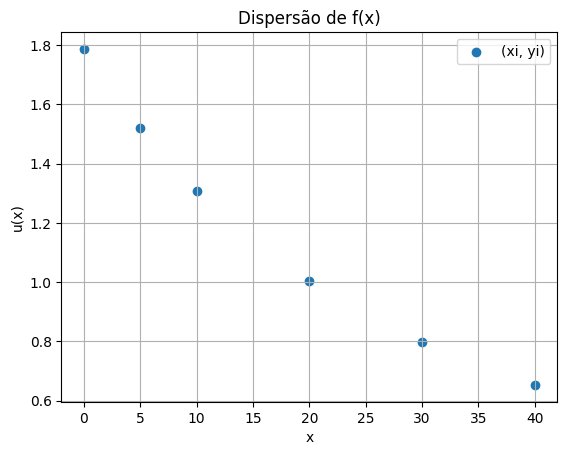

In [191]:
plt.scatter(x, y, label='(xi, yi)')
plt.grid(True)
plt.title('Dispersão de f(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

## Questão B

In [192]:
fx_lin, syx, r_lin = linear_regression(x, y)
print(f'{fx_lin[1]}x + {fx_lin[0]}')

-0.027703999999999996x + 1.6623866666666665


Na linearização dos dados da função potencial, aplica-se a função ln( ) em ambos os lados da equação, gerando:
    
**ln(y) = ln(a) + b.ln(x)**

Entretanto, x=0 não está definido na função ln(x), logo, não há como estimar uma curva potencial que represente f(x).

Uma possível alternativa seria definir para x um valor muito próximo de 0.

In [193]:
x_pow = x.copy()
x_pow[0] = 1e-10

log_x = np.log(x_pow)
log_y = np.log(y)

fx_pow, syx, r_pow = linear_regression(log_x, log_y)
fx_pow, r_pow

([0.06629115497766302, -0.024143859974069], 0.4323265822482581)

Porém, analisando o coeficiente de determinação, vê-se que a curva não se ajustou adequadamente aos dados recebidos.

In [194]:
fx_sq, r_qu = quadratic_regression(x, y)
fx_sq, r_qu

([0.0005483416614615858, -0.049493366021236704, 1.7672449843847593],
 0.9982819718683001)

In [195]:
linsp = np.linspace(x[0], x[-1], 1000)

In [196]:
f0 = lambda x: fx_lin[0] + fx_lin[1]*x
f1 = lambda x: fx_sq[0]*(x**2) + fx_sq[1]*x + fx_sq[2]
f2 = lambda x: np.exp(fx_pow[0])*(x**fx_pow[1])

## Questão C

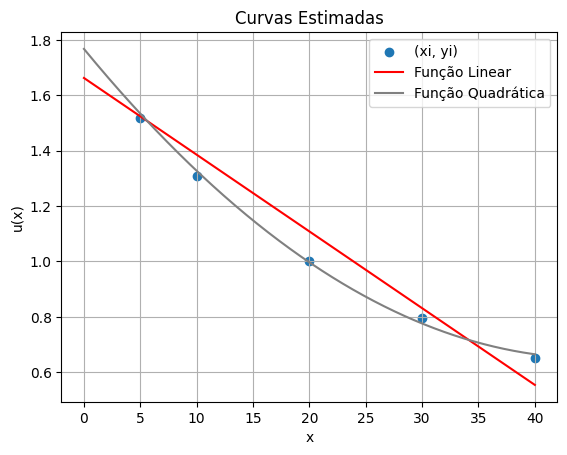

In [197]:
plt.scatter(x[1:],y[1:], label='(xi, yi)')
plt.plot(linsp, f0(linsp),color='red', label='Função Linear')
plt.plot(linsp, f1(linsp),color='gray', label='Função Quadrática')
plt.grid(True)
plt.title('Curvas Estimadas')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

In [198]:
mse = []
mse.append(np.sum((f0(x) - y)**2)/(len(x)))
mse.append(np.sum((f1(x) - y)**2)/(len(x)))

In [199]:
scores = {'u(7.5)': [f0(7.5), f1(7.5)],
          'R²':[r_lin, r_qu],
          'MSE': mse}
pd.DataFrame(scores, index=['Linear', 'Quadrática'])

,u(7.5),R²,MSE
Linear,1.454607,0.954079,0.007311
Quadrática,1.426889,0.998282,0.000274


Olhando para o gráfico, é claramente perceptível que a curva que melhor se ajusta aos pontos dados é a parabola, pelo seu decrescimento mais suave. Não só graficamente, mas também através do coeficiente de determinação, onde ele foi o mais próximo de 1, e do Erro Médio Quadrático que é aproximadamente 27 vezes menor que o da reta.